In [2]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
hparams = dict(
    # datamodule
    hdf_path='./data/ProteomeTools.hdf',
    batch_size=1024,
    train_val_split=0.9,
    cdhit_threshold=0.5,
    cdhit_word_length=3,
    tmp_env='TMPDIR',
    num_workers=20,
    random_state=0,
    
    # model
    model_dim=512,
    model_depth=8,
    num_heads=8,
    lr=1e-4,
    dropout=0.1, 
    max_length=100,
    use_cls_token=True,
    condition_at='tgt',

    # trainer
    num_gpus=1,
    max_epochs=100,
    precision=32,
    strategy='ddp',
    
    # cluster
    num_nodes=8,
    num_cpus=20,
    conda_env='MSPretraining',
    time='0-24:00:00',
    
    # tensorboard
    login_node='login-2'
)

In [5]:
args = ' '.join([f'--{k} {v}' for k,v in hparams.items()])

## SBATCH --signal=SIGUSR1@90

slurm = f'''#!/bin/bash -l

#SBATCH --nodes={hparams['num_nodes']}
#SBATCH --gres=gpu:volta:{hparams['num_gpus']}
#SBATCH --ntasks-per-node={max(1,hparams['num_gpus'])}
#SBATCH --cpus-per-task={hparams['num_cpus']}
#SBATCH --time={hparams['time']}

source activate {hparams['conda_env']}
''' + '''
export NCCL_DEBUG=INFO
export PYTHONFAULTHANDLER=1

# Set some environment variables needed by torch.distributed 
export MASTER_ADDR=$(hostname -s)
# Get unused port
export MASTER_PORT=$(python -c 'import socket; s=socket.socket(); s.bind(("", 0)); print(s.getsockname()[1]); s.close()')

echo "MASTER_ADDR : ${MASTER_ADDR}"
echo "MASTER_PORT : ${MASTER_PORT}"
''' + f'''
srun python train.py {args}
'''

%store slurm >submit.sh

Writing 'slurm' (str) to file 'submit.sh'.


In [6]:
!sbatch submit.sh

Submitted batch job 15827685


In [6]:
from src.torch_helpers import start_tensorboard

start_tensorboard(login_node=hparams['login_node'])

/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from src.datamodule import MSDataModule
from src.model import MSTransformer

[last_ckpt] = !ls -t1 ./lightning_logs/version_15815343/checkpoints/*.ckpt | head -n1
print(last_ckpt)

model = MSTransformer.load_from_checkpoint(last_ckpt)
dm = MSDataModule(**dict(model.hparams))

dm.setup()
model = model.cpu()
model.eval();

/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


./lightning_logs/version_15815343/checkpoints/epoch=26-step=8855.ckpt


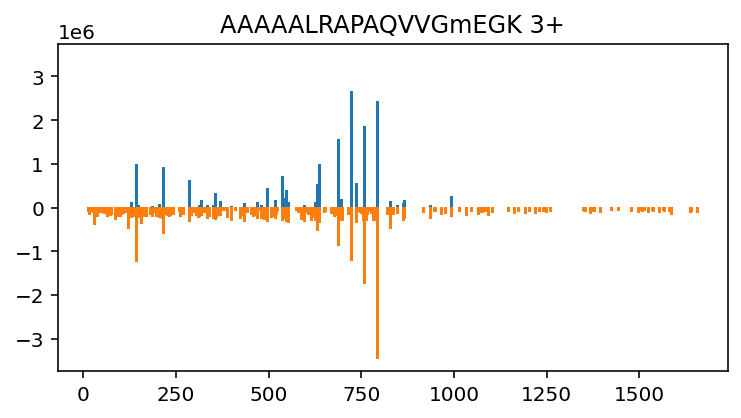

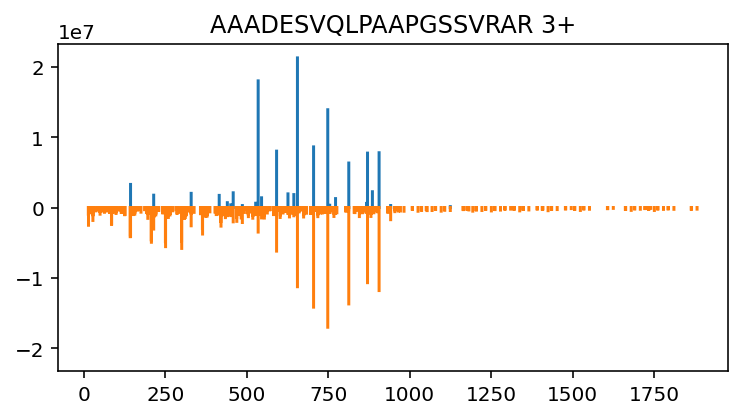

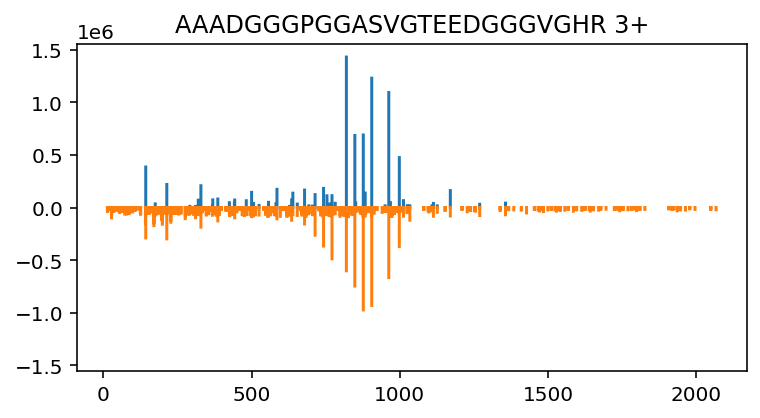

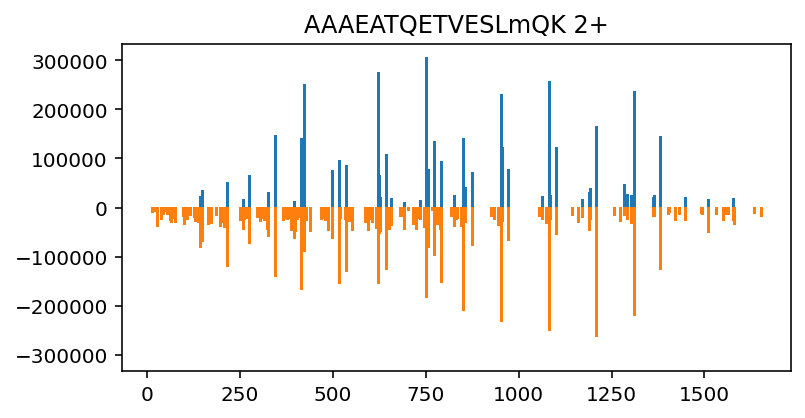

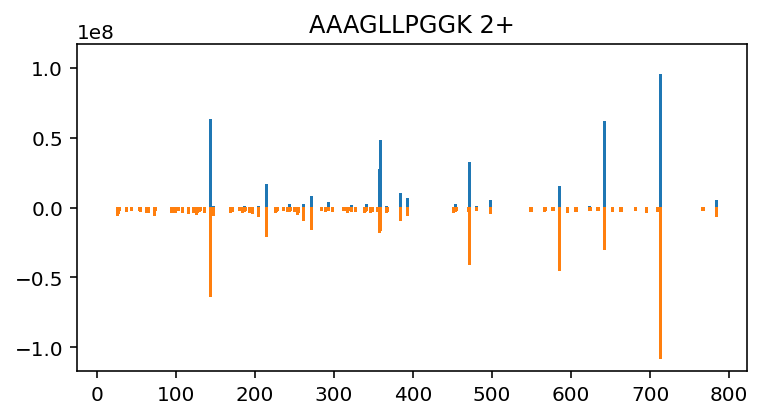

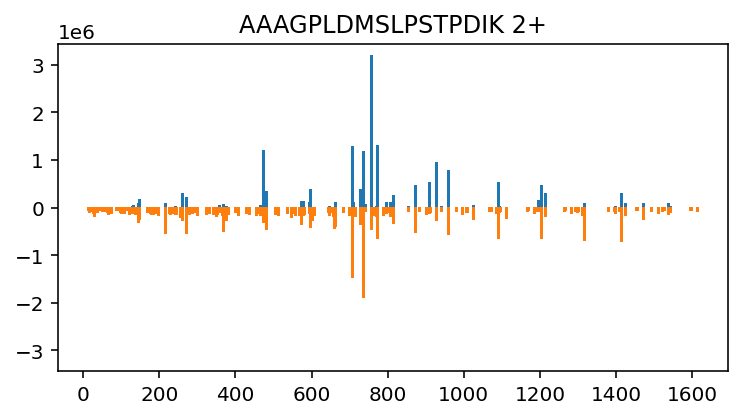

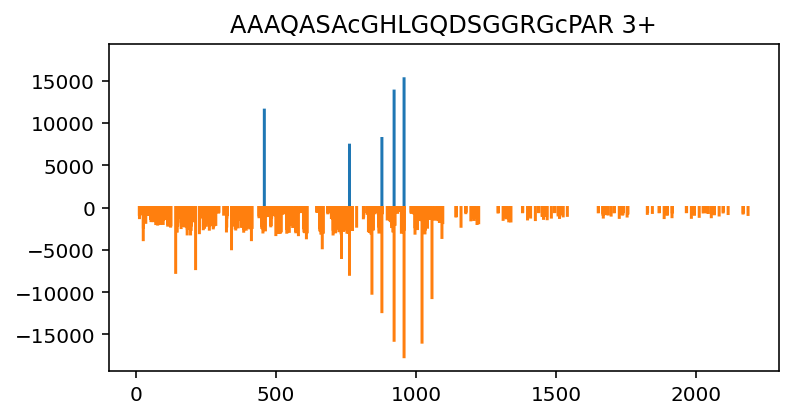

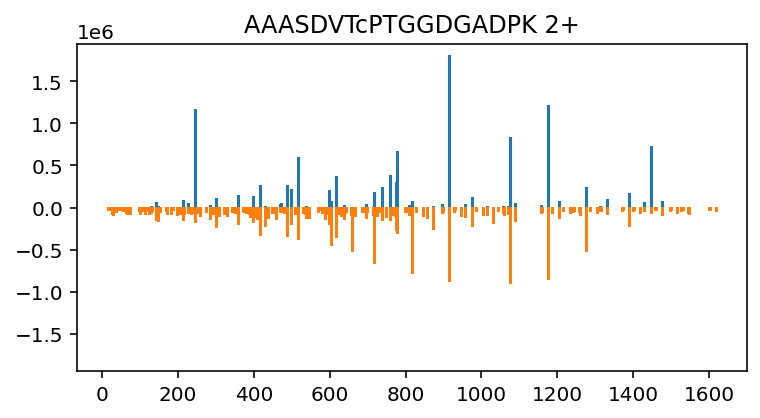

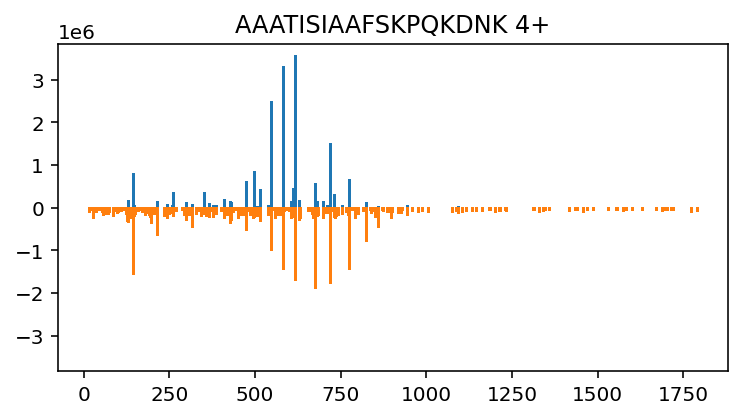

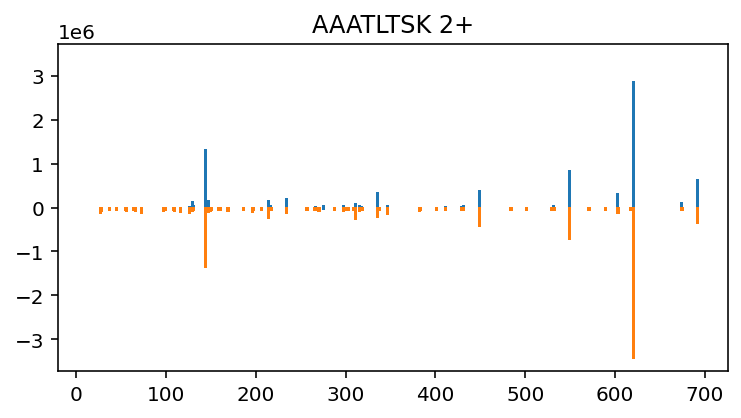

In [ ]:
from src.plotting import faststem
from src.spectrum import fragment_mz_tensor
from tqdm import tqdm

for i, batch in enumerate(dm.predict_dataloader(shuffle=False)):
    batch['y_pred'] = model.predict_step(batch)

    mz = fragment_mz_tensor(batch['sequence'][0]).ravel()
    y = batch['y'][0].detach().cpu().numpy().ravel()
    y_pred = batch['y_pred'][0].detach().cpu().numpy().ravel()
    
    plt.figure(figsize=(6,3))
    faststem(mz,y)
    faststem(mz,-y_pred)
    yl = max(np.abs(plt.ylim()))
    plt.ylim([-yl,yl])
    plt.title(f"{batch['sequence'][0]} {batch['charge'][0]}+")
    
    if i == 10:
        break